# Compute intruder head orientation relative to the resident
## Imports

In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns

from movement.io import load_poses

from utils import magnitude, normalize
from plotting import (
    plot_head_orientation_polar_histogram,
    plot_histogram_with_percentiles,
)

In [2]:
# Plotting style
sns.set(style="ticks", context="notebook")

## Define paths for input/output

In [3]:
# Exchange the path to the data folder with the correct one on your system
data_folder = Path("/Users/nsirmpilatze/Data/in2research2024")
assert data_folder.exists()  # Will raise an error if the path does not exist

# Clean data folder must already exist
clean_data_folder = data_folder / "clean_data"
assert clean_data_folder.exists()
print(f"Clean data will be loaded from {clean_data_folder}")

# Plots folder (for saving diagnostic plots)
plots_folder = data_folder / "plots"
plots_folder.mkdir(exist_ok=True)
print(f"Diagnostic plots will be saved in {plots_folder}")

# Create a folder to save results in the current directory
results_folder = Path.cwd() / "results"
results_folder.mkdir(exist_ok=True)
print(f"Results and final plots will be saved in {results_folder}")

Clean data will be loaded from /Users/nsirmpilatze/Data/in2research2024/clean_data
Diagnostic plots will be saved in /Users/nsirmpilatze/Data/in2research2024/plots
Results and final plots will be saved in /Users/nsirmpilatze/Code/NIU/In2Research-2024/results


## Define metadata about the tracked animals and keypoints

In [4]:
pair_names = ["SB019_female4", "SB019_male2", "SB021_female2", "SB021_male1"]
individuals = ["resident", "intruder"]
keypoint_names = [
    "nose",
    "leftear",
    "rightear", 
    "butt",
    "neck",
    "lefthip",
    "righthip",
    "leftshoulder", 
    "rightshoulder",
    "lowerback",
]
# Sectonds in the video where the interaction starts
# This was used to restrict the analysis to the interaction period
interaction_onsets = {
    "SB019_female4": 30,
    "SB019_male2": 29,
    "SB021_female2": 40,
    "SB021_male1": 31,
}

## Analyse all pairs of mice
For each pair derive the angle between the head direction of the intruder,
and the direction from the resident's head to the intruder's head.
The result is a list of angles (in radians) for each frame.
The range is from -pi to pi, where 0 means the intruder is facing towards the resident,
and -pi/pi means the intruder is facing away from the resident.
Positive angles indicate that the resident is to the left
of the intruder's head vector, while negative angles indicate that the
resident is to the right.

In [5]:
angles_per_pair = {}  # dictionary to store the computed angles for each pair
z_vector = np.array([0, 0, -1])  # unit vector pointing outwards from the screen

for pair_name in pair_names:
    # Print the names of the individuals in the pair
    resident_id, intruder_id = pair_name.split("_")
    print(f"\nResident: {resident_id} | Intruder: {intruder_id}")

    # Load the clean data
    ds = load_poses.from_dlc_file(clean_data_folder / f"{pair_name}_clean.csv", fps=50)
    position = ds.position  # Extract the position data
    print(f"Loaded data from {pair_name}_clean.csv")

    # Define points representing each individual's head
    # For the intruder, use the midpoint between the ears
    intruder_head = position.sel(individuals="intruder", keypoints=["leftear", "rightear"]).mean(dim="keypoints")
    print("Using the midpoint between the ears as proxy for the intruder's head.")
    # For the resident, use the neck (ears are often not visible)
    resident_head = position.sel(individuals="resident", keypoints="neck", drop=True)
    print("Using the neck as proxy for the resident's head.")

    # Compute the vector going from the right ear to the left ear of the intruder
    intruder_right_ear = position.sel(individuals="intruder", keypoints="rightear")
    intruder_left_ear = position.sel(individuals="intruder", keypoints="leftear")
    intruder_ear_vector = intruder_left_ear - intruder_right_ear
    print("Computed vector from intruder's right ear to left ear.")
    
    # The magnitude of the ear vector is the distance between the ears
    intruder_ear_distance = magnitude(intruder_ear_vector)

    # Plot this distance with 5th and 95th percentiles shown
    percentiles = [5, 95]
    plot_histogram_with_percentiles(
        intruder_ear_distance,
        percentiles=percentiles,
        n_bins=50,
        xlabel="Inter-ear distance (pixels)",
        # save in diagnostic plots folder
        save_path=plots_folder / f"{pair_name}_intruder_ear_distance_histogram.png",
    )
    print("Plotted histogram of intruder's ear distance.")

    # Keep data if the inter-ear distance is not too small or too large
    # We'll keep data between the 5th and 95th percentiles of the inter-ear distance
    perc5, perc95 = np.nanpercentile(intruder_ear_distance, percentiles)
    keep_condition = (intruder_ear_distance > perc5) & (intruder_ear_distance < perc95)
    intruder_ear_vector = intruder_ear_vector.where(keep_condition)
    intruder_head = intruder_head.where(keep_condition)
    print(
        "Rejected data where the intruder inter-ear distance was "
        f"<{perc5:.2f} or >{perc95:2f} pixels."
    )

    # Compute the intruder's head direction vector
    # This is computed as the cross product of the vector from the right to the left ear
    # and the unit vector [0, 0, -1] (vector pointing outwards from the screen).
    intruder_head_vector = xr.DataArray(
        np.cross(intruder_ear_vector, z_vector)[:, :2],
        dims=("time", "space"),
        coords={"time": ds.time,"space": ds.space},
    )
    print("Computed intruder's head direction vector.")

    # Define a vector pointing from intruder's head to resident's head
    intruder_to_resident_vector = resident_head - intruder_head
    print("Computed vector pointing from intruder's head to resident's head.")

    # Normalize the two vectors
    intruder_head_vector = normalize(intruder_head_vector)
    intruder_to_resident_vector = normalize(intruder_to_resident_vector)
    print("Normalized the two vectors by their magnitudes.")

    # Take the dot product between the intruder's head vector
    # And the vector pointing from the intruder's head to the resident's head
    # Since both vectors are normalized, this will give the cosine of the angle
    # between the two vectors, hence we can derive the angle in radians,
    # which will range from 0 (the two vectors are perfectly parallel)
    # to pi (the two vectors are perfectly anti-parallel).
    # In degrees, this will range from 0 to 180.
    dot_product = xr.dot(intruder_head_vector, intruder_to_resident_vector, dim="space")
    unsigned_angle_radians = xr.apply_ufunc(np.arccos, dot_product)
    print("Computed unsigned angle between intruder's head direction and vector to resident")

    # Compute the signed angle, which will range from -pi to pi (0 to 360 degrees)
    # Values close to 0 indicate that the intruder is facing the resident
    # Values close to -pi/pi indicate that the intruder is facing away from the resident
    # Positive values indicate that the resident is to the left of the intruder
    # Negative values indicate that the resident is to the right of the intruder
    intruder_head_vector_3d = np.hstack([intruder_head_vector, np.zeros((intruder_head_vector.shape[0], 1))])
    intruder_to_resident_vector_3d = np.hstack([intruder_to_resident_vector, np.zeros((intruder_to_resident_vector.shape[0], 1))])
    cross_product = xr.DataArray(
        np.cross(intruder_head_vector_3d, intruder_to_resident_vector_3d),
        dims=("time", "space"),
        coords={"time": ds.time, "space": ["x", "y", "z"]},
    )
    sign = np.sign(np.dot(cross_product, z_vector))
    signed_angle_radians = sign * unsigned_angle_radians
    print("Computed signed angle between intruder's head direction and vector to resident")

    # Store the signed angles in the dictionary
    angles_per_pair[pair_name] = signed_angle_radians



Resident: SB019 | Intruder: female4
Loaded data from SB019_female4_clean.csv
Using the midpoint between the ears as proxy for the intruder's head.
Using the neck as proxy for the resident's head.
Computed vector from intruder's right ear to left ear.
Plotted histogram of intruder's ear distance.
Rejected data where the intruder inter-ear distance was <14.39 or >49.994214 pixels.
Computed intruder's head direction vector.
Computed vector pointing from intruder's head to resident's head.
Normalized the two vectors by their magnitudes.
Computed unsigned angle between intruder's head direction and vector to resident
Computed signed angle between intruder's head direction and vector to resident

Resident: SB019 | Intruder: male2
Loaded data from SB019_male2_clean.csv
Using the midpoint between the ears as proxy for the intruder's head.
Using the neck as proxy for the resident's head.
Computed vector from intruder's right ear to left ear.
Plotted histogram of intruder's ear distance.
Reject

## Save the results to files
Save each pair's angles (in radians) to a .csv file.

Note that there are lot of missing values, where data were dropped.
These appear as blank cells in the .csv files.

In [6]:
for i, pair_name in enumerate(pair_names):
    angles_in_radians = angles_per_pair[pair_name]
    # covert to a pandas dataframe
    df = angles_in_radians.drop_vars("individuals").to_dataframe("angle_radians")
    # generate a column with angles in degrees
    df["angle_degrees"] = np.degrees(df["angle_radians"])
    # Shift time by the interaction onset
    # so that the saved times correspond to the time in the video
    df.index = df.index + interaction_onsets[pair_name]
    # rename index to seconds_in_video
    df.index.name = "seconds_in_video"
    # Save the dataframe to a CSV file
    save_path = results_folder / f"{pair_name}_angles.csv"
    df.to_csv(save_path)
    print(f"Saved angles for {pair_name} to {save_path}")

Saved angles for SB019_female4 to /Users/nsirmpilatze/Code/NIU/In2Research-2024/results/SB019_female4_angles.csv
Saved angles for SB019_male2 to /Users/nsirmpilatze/Code/NIU/In2Research-2024/results/SB019_male2_angles.csv
Saved angles for SB021_female2 to /Users/nsirmpilatze/Code/NIU/In2Research-2024/results/SB021_female2_angles.csv
Saved angles for SB021_male1 to /Users/nsirmpilatze/Code/NIU/In2Research-2024/results/SB021_male1_angles.csv


## Plot the angles in a polar histogram
The plot is saved to the results folder.

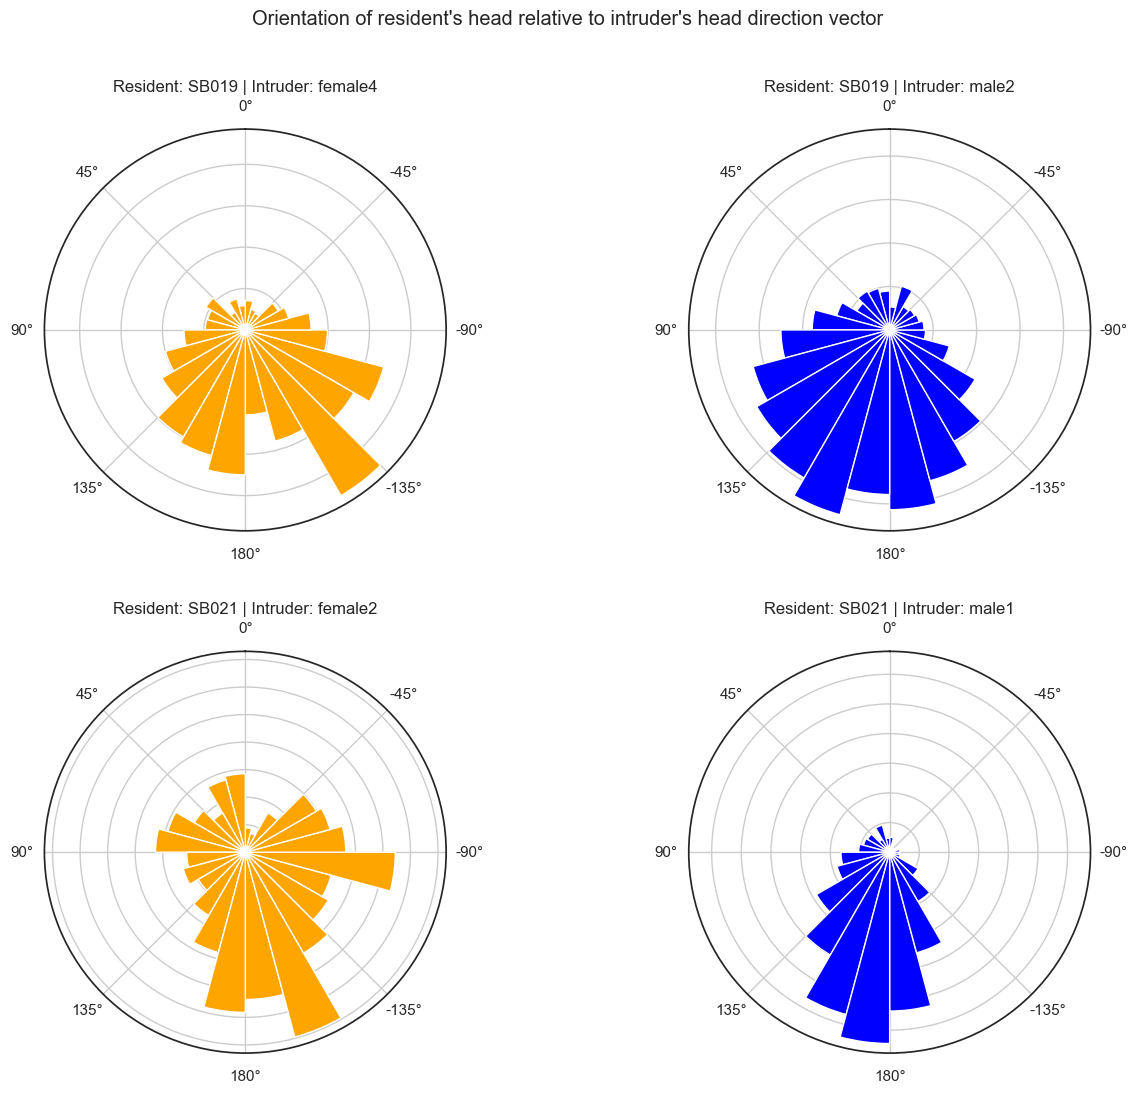

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection="polar"))

for i, pair_name in enumerate(pair_names):
    resident_id, intruder_id = pair_name.split("_")
    angles_in_radians = angles_per_pair[pair_name]
    ax_i = ax[i // 2, i % 2]
    plot_head_orientation_polar_histogram(
        angles_in_radians,
        resident_id=resident_id,
        intruder_id=intruder_id,
        ax=ax_i,
    )

fig.subplots_adjust(hspace=0.3, wspace=0.3, left=0.025, right=0.975)
fig.suptitle("Orientation of resident's head relative to intruder's head direction vector")
plt.savefig(results_folder / "Head_orientation_polar_histograms.png")